## Test Adult dataset
- Document of dataset: 
    + https://fairlearn.org/main/user_guide/datasets/acs_income.html#dataset-description
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_adult.html
    + https://archive.ics.uci.edu/dataset/2/adult


In [1]:
# Custom imports
# import my_helper # my helper functions

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd
import shap

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [2]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
from fairlearn.datasets import fetch_diabetes_hospital

# Data processing
X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
# The columns readmit_binary and readmitted are included in X -> remove both to avoid target leakage
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)

### Remove Unknown/Invalid gender

In [3]:
# Get a boolean mask for rows where gender is not 'Unknown/Invalid' (which was encoded as 2)
valid_gender_mask = X['gender'] != 'Unknown/Invalid'

In [4]:
# Filter both X and y using the same mask
X = X[valid_gender_mask]
y = y[valid_gender_mask]

In [5]:
print("Remaining rows after removing 'Unknown/Invalid' gender values:")
print(X['gender'].value_counts())

Remaining rows after removing 'Unknown/Invalid' gender values:
gender
Female    54708
Male      47055
Name: count, dtype: int64


## Data Preprocessing

### Label Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

# 1. Make a copy and find *all* categorical columns (including "Sex")
X_enc = X.copy()
all_cat_cols = X_enc.select_dtypes(['object', 'category']).columns

# 2. Encode each categorical, storing its mapping
label_mappings = {}
for col in all_cat_cols:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


### Over-sampling imbalanced class

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=7)
X_smote, y_smote = smote.fit_resample(X_enc, y)


In [8]:
y_smote_df = pd.DataFrame(y_smote)
print(y_smote_df.value_counts(normalize=True))

readmit_30_days
0                  0.833335
1                  0.166665
Name: proportion, dtype: float64


In [9]:
# 3. Now drop the sensitive column
X_enc_drop = X_smote.drop(columns=["gender"])

# 4. Recompute your final cat_cols _after_ dropping
cat_cols = [c for c in all_cat_cols if c != "gender"]

# 5. Compute cardinalities in the same order as cat_cols
cardinalities = [len(label_mappings[c]) for c in cat_cols]

print("Final categorical columns:", cat_cols)
print("Their cardinalities:      ", cardinalities)

# Your numeric columns remain:
num_cols = [c for c in X_enc_drop.columns if c not in cat_cols]

Final categorical columns: ['race', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
Their cardinalities:       [6, 3, 2, 3, 6, 5, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2]


### Split and format

In [10]:
# Train/test split
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_enc_drop, y_smote, X_smote['gender'], test_size=0.2, random_state=7
)

In [11]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 

# Convert to numpy / tensors
X_train_num = X_train[num_cols].to_numpy(dtype=np.float32)
X_test_num  = X_test[num_cols].to_numpy(dtype=np.float32)

X_train_cat = X_train[cat_cols].to_numpy(dtype=np.int64)
X_test_cat  = X_test[cat_cols].to_numpy(dtype=np.int64)

y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

X_train_num_t = torch.from_numpy(X_train_num)
X_train_cat_t = torch.from_numpy(X_train_cat)
X_test_num_t = torch.from_numpy(X_test_num)
X_test_cat_t = torch.from_numpy(X_test_cat)

y_train_t = torch.from_numpy(y_train_np)
y_test_t  = torch.from_numpy(y_test_np)

In [12]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (86789, 21)
Shape of y_train:  (86789,)
Shape of A_train:  (86789,)
Shape of A_test:  (21698,)
Shape of X_test:  (21698, 21)
Shape of y_test:  (21698,)


## Train

In [13]:
from rtdl_revisiting_models import FTTransformer

# Input dims
d_num = X_train_num.shape[1]
cat_cardinalities = cardinalities
n_cont_features = len(num_cols)
d_out = 2

default_kwargs = FTTransformer.get_default_kwargs()
# default_kwargs['n_blocks'] = 2
default_kwargs['d_block'] = 32
default_kwargs['attention_n_heads'] = 1
# default_kwargs['attention_dropout'] = 0.2   # originally ~0.1
# default_kwargs['ffn_dropout']       = 0.2   # originally ~0.1
# default_kwargs['residual_dropout']  = 0.2   # originally 0.0 or tiny

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **default_kwargs,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(X_train_num_t, X_train_cat_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [14]:
# Load the model
model.load_state_dict(torch.load("saved_model/fttransformer_diabetes.pth", map_location=torch.device('cpu')))

C:\Users\hungd\AppData\Local\Temp\ipykernel_21132\3167305945.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model/fttransformer_

<All keys matched successfully>

In [15]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8424


## Results

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

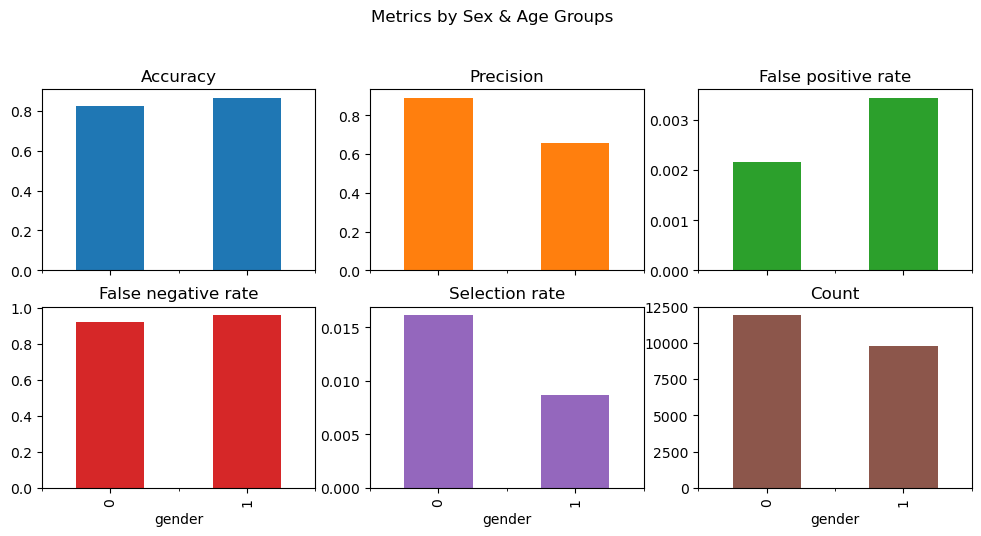

In [16]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex & Age Groups",
)

In [17]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0391
Precision difference: 0.2318
True positive rate difference: 0.0353
False positive rate difference: 0.0013
Demographic parity difference: 0.0074
Equalized odds difference: 0.0353
